# AMPSphere v.2022-03

This is a notebook meant to form the set of notebooks used to analyze the data in AMPSphere and write the manuscript:

__AMPSphere: Global survey of prokaryotic antimicrobial peptides shaping microbiomes__

### The diversity of c_AMPs is directly linked to the diversity of microbes

We show that normalized measures of diversity of c_AMPs and microbes are highly correlated.

First, we calculate the diversity of c_AMPs per sample:

In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from scipy.stats import spearmanr

In [2]:
# define the Shannon entropy formula
def shannon(df):
    f1 = df[0]/df[0].sum()
    f2 = np.log(f1)
    return -sum(f1*f2)

In [3]:
# load data
gmsc = pd.read_table('data/gmsc_amp_genes_envohr_source.tsv.gz')

# sample info
sta = pd.read_table('data/samples-min500k-assembly-prodigal-stats.tsv.gz')

sta = sta[['sample_accession',
           'assembly_total_length']]

sta = sta.rename({'sample_accession': 'sample',
                  'assembly_total_length': 'assembled_bp'},
                 axis=1)

In [4]:
# shannon H diversity for c_AMPs
d = gmsc.groupby(['amp', 'sample'])
d = d.agg('size')
d = d.reset_index()
d = d.sort_values(by='sample')

d = d.groupby('sample')
d = d.apply(lambda x: shannon(x))
d = d.reset_index().rename({0: 'shannon_H_amp'}, axis=1)

In [5]:
# amp counts - redundant and nr
d2 = gmsc.groupby('sample').agg('size').reset_index()
d2 = d2.rename({0: 'redundant_amps'}, axis=1)

d3 = gmsc[['sample', 'amp']].drop_duplicates()
d3 = d3.groupby('sample').agg('size').reset_index()
d3 = d3.rename({0: 'nr_amps'}, axis=1)

In [6]:
# merge intermediate files
d = d.merge(on='sample', right=d2)
d = d.merge(on='sample', right=d3)

In [7]:
d = d.merge(on='sample', right=sta)

d4 = gmsc[['sample',
           'is_metagenomic',
           'general_envo_name']]

d4 = d4.drop_duplicates()
d = d.merge(on='sample', right=d4)
d = d[d.is_metagenomic == True]

amps = d[['sample',
          'general_envo_name',
          'assembled_bp',
          'redundant_amps',
          'nr_amps',
          'shannon_H_amp']]

amps

,sample,general_envo_name,assembled_bp,redundant_amps,nr_amps,shannon_H_amp
0,100822046-x-0-x-ST,human gut,110512142,62,60,4.082415
1,103092734-palatinetonsils3,human mouth,197407958,98,97,4.570822
2,103092734-subgingivalplaque3,human mouth,136837353,73,72,4.271469
3,103092734-supragingivalplaque3,human mouth,106787798,50,50,3.912023
4,1062629-24-0-0,human gut,180877636,114,114,4.736198
...,...,...,...,...,...,...
61388,tigress_HD.S14-x-392-x-OR,human saliva,227034094,92,91,4.506720
61389,tigress_HD.S14-x-392-x-ST,human gut,170456936,70,69,4.228691
61390,tigress_HD.S14-x-60-x-ST,human gut,176591235,86,85,4.438228
61391,tigress_HD.S14-x-7-x-OR,human saliva,73749208,20,20,2.995732


Secondly, we calculate the diversity of microbial species per sample:

* As the size of this table is much larger, than it is better to compute using the C++ optimized option

In [8]:
# load motus --
# this table is too big, so we will be computing
# the diversity by rows

def shannon_motus(i):
    n = i[i.columns[0]].tolist()[0]
    f1 = np.asarray(i[i.columns[1:]])
    f1 = f1[(f1 != 0) & ~(np.isnan(f1))]
    ft = sum(f1)
    f1 = f1/ft
    f2 = np.log(f1)
    return (n, -sum(f1*f2))

motus = []
for i in pd.read_table('data/freeze.v2.motusv2_5.mg3.insertcount.tsv.xz',
                       sep='\t', 
                       header='infer', 
                       chunksize=1):
    motus.append(shannon_motus(i))

motus = pd.DataFrame(motus, columns=['sample', 'shannon_H'])

len(motus)

62406

In [9]:
# eliminate samples containing duplicates
res = dict(Counter(motus.index))
res = [k for k, v in res.items() if v > 1]
motus = motus.drop(res, axis=0)

motus

,sample,shannon_H
0,SAMN04622706,3.259813
1,SAMN04622708,3.437713
2,SAMN04622709,2.534813
3,SAMN04622711,2.509970
4,SAMN04622713,2.050824
...,...,...
62401,G80292,1.842696
62402,G80293,3.003529
62403,G80294,3.225755
62404,G80295,2.685188


Then, using the both diversity matrices, we calculate the tests:

In [10]:
div = amps.merge(on='sample',
                 right=motus)

div['amp_density'] = div.redundant_amps * 1e9 / div.assembled_bp

Text(336.9714285714286, 0.5, 'AMPs diversity - Shannon H')

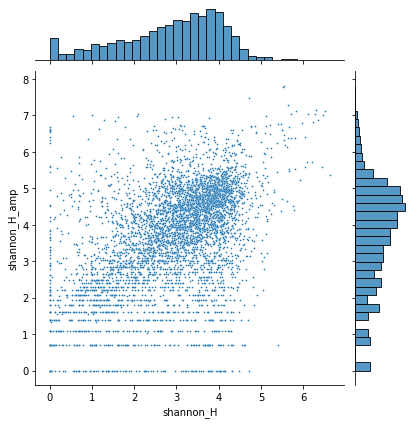

In [11]:
sns.jointplot(data=div.sample(5000),
              x='shannon_H',
              y='shannon_H_amp',
              s=3)

plt.xlabel('Species diversity - Shannon H')
plt.ylabel('AMPs diversity - Shannon H')

In [12]:
spearmanr(div.shannon_H_amp, div.shannon_H)
## SpearmanrResult(correlation=0.4679178079882997, pvalue=0.0)

SpearmanrResult(correlation=0.4789007118181432, pvalue=0.0)

In [13]:
spearmanr(div.shannon_H, div.nr_amps)
## SpearmanrResult(correlation=0.46741093627128366, pvalue=0.0)

SpearmanrResult(correlation=0.4784010299855933, pvalue=0.0)

In [14]:
spearmanr(div.shannon_H, div.redundant_amps)
## SpearmanrResult(correlation=0.4662465067984268, pvalue=0.0)

SpearmanrResult(correlation=0.4771680039836699, pvalue=0.0)

In [15]:
spearmanr(div.shannon_H, div.amp_density)
## SpearmanrResult(correlation=0.07109297647828566, pvalue=1.7047089362702838e-67)

SpearmanrResult(correlation=0.07198413577228303, pvalue=3.184277952344457e-70)

In [16]:
spearmanr(div.assembled_bp, div.shannon_H_amp)
## SpearmanrResult(correlation=0.9390838989154104, pvalue=0.0)

SpearmanrResult(correlation=0.9397452748416225, pvalue=0.0)

In [17]:
spearmanr(div.assembled_bp, div.amp_density)
## SpearmanrResult(correlation=-0.11880114166275109, pvalue=7.80750789022028e-186)

SpearmanrResult(correlation=-0.11642159722107948, pvalue=2.688420030554117e-181)

In [18]:
spearmanr(div.shannon_H_amp, div.amp_density)
## SpearmanrResult(correlation=0.16354565455715206, pvalue=0.0)

SpearmanrResult(correlation=0.16425794445969033, pvalue=0.0)

In [19]:
div = div.rename({'shannon_H': 'shannon_H_mOTUs'}, axis=1)

div=div[['sample', 'general_envo_name', 'assembled_bp',
         'redundant_amps', 'nr_amps', 'amp_density',
         'shannon_H_amp', 'shannon_H_mOTUs']]

# div.to_csv('diversity_samples_AMPSphere.tsv.gz', sep='\t', header=True, index=None)

div

,sample,general_envo_name,assembled_bp,redundant_amps,nr_amps,amp_density,shannon_H_amp,shannon_H_mOTUs
0,100822046-x-0-x-ST,human gut,110512142,62,60,561.024326,4.082415,3.386159
1,103092734-palatinetonsils3,human mouth,197407958,98,97,496.433887,4.570822,3.638471
2,103092734-subgingivalplaque3,human mouth,136837353,73,72,533.480065,4.271469,4.235631
3,103092734-supragingivalplaque3,human mouth,106787798,50,50,468.218288,3.912023,3.768959
4,1062629-24-0-0,human gut,180877636,114,114,630.260338,4.736198,4.030651
...,...,...,...,...,...,...,...,...
60407,tigress_HD.S14-x-392-x-OR,human saliva,227034094,92,91,405.225481,4.506720,4.043912
60408,tigress_HD.S14-x-392-x-ST,human gut,170456936,70,69,410.660907,4.228691,3.767198
60409,tigress_HD.S14-x-60-x-ST,human gut,176591235,86,85,487.000388,4.438228,3.654902
60410,tigress_HD.S14-x-7-x-OR,human saliva,73749208,20,20,271.189353,2.995732,3.779485


Text(336.9714285714286, 0.5, 'AMP density')

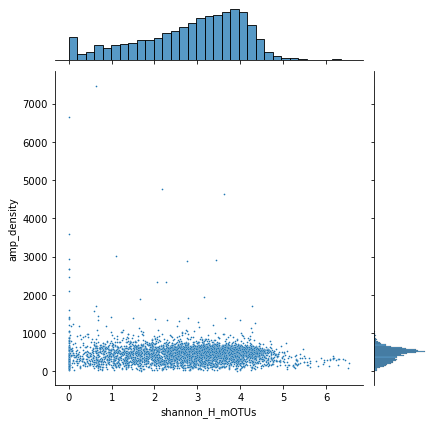

In [20]:
sns.jointplot(data=div.sample(5000),
              x='shannon_H_mOTUs',
              y='amp_density',
              s=3)

plt.xlabel('Species diversity - Shannon H')
plt.ylabel('AMP density')

Text(336.9714285714286, 0.5, 'AMPs diversity - Shannon H')

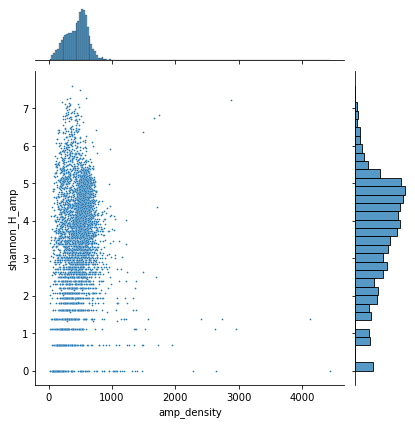

In [21]:
sns.jointplot(data=div.sample(5000),
              x='amp_density',
              y='shannon_H_amp',
              s=3)

plt.xlabel('AMP density')
plt.ylabel('AMPs diversity - Shannon H')